## Average Correctness Scores on Intermediate Generated Layouts with and without Layout-Corrector
Fig. 9 in our paper

In [ ]:
%cd ../
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import copy
import json
import logging
import os
from collections import defaultdict
from copy import deepcopy
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import torch
import torch.nn as nn
import torchvision.transforms as T
from einops import rearrange
from fsspec.core import url_to_fs
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
from torch_geometric.loader import DataLoader
from trainer.data.util import sparse_to_dense
from trainer.helpers.layout_tokenizer import LayoutSequenceTokenizer
from trainer.helpers.sampling import sample
from trainer.helpers.util import set_seed
from trainer.hydra_configs import TestConfig
from trainer.models.categorical_diffusion.util import index_to_log_onehot
from trainer.models.common.util import load_model

plt.style.use(['science','no-latex', 'grid'])

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/usrs/shoiwai/miniconda3/envs/layout_corrector_test_env_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# utility
def load_config(config_path: str):
    fs, _ = url_to_fs(config_path)
    if fs.exists(config_path):
        with fs.open(config_path, "rb") as file_obj:
            cfg = OmegaConf.load(file_obj)
        return cfg
    else:
        raise FileNotFoundError


def build_model(
    train_cfg: DictConfig, 
    device: str
) -> nn.Module:
    ## Define Models
    tokenizer = LayoutSequenceTokenizer(
        data_cfg=train_cfg.data, dataset_cfg=train_cfg.dataset
    )
    model = instantiate(train_cfg.model)(
        backbone_cfg=train_cfg.backbone, tokenizer=tokenizer
    ).to(device)
    return model

In [4]:
# configuration
DIFFUSION_JOB_DIR = "./download/pretrained_weights/rico25/layoutdm/0/"
CORRECTOR_JOB_DIR ="./download/pretrained_weights/rico25/layout_corrector/0/"
NUM_SAMPLES = 500

In [5]:
# load models

# layout generation model
diff_config_path = os.path.join(DIFFUSION_JOB_DIR, "config.yaml")
diff_train_cfg = load_config(diff_config_path)
model = build_model(diff_train_cfg, device=device)
model = load_model(
    model=model,
    ckpt_dir=DIFFUSION_JOB_DIR,
    device=device,
    best_or_final="best"
)
model.eval()
assert model.model.use_padding_as_vocab


# corrector
corr_config_path = os.path.join(CORRECTOR_JOB_DIR, "config.yaml")
corr_train_cfg = load_config(corr_config_path)
corrector = None if corr_train_cfg is None else build_model(corr_train_cfg, device=device)
corrector = load_model(
    model=corrector,
    ckpt_dir=CORRECTOR_JOB_DIR,
    device=device,
    best_or_final="best"
)
corrector.eval();

In [6]:
sampling_cfg = corr_train_cfg.sampling

In [7]:
tokenizer = model.tokenizer
mask_id, pad_id = tokenizer.name_to_id("mask"), tokenizer.name_to_id("pad")
dataset = instantiate(corr_train_cfg.dataset)(split="test", transform=None)
kwargs = {
    "batch_size": NUM_SAMPLES,
    "num_workers": 8,
    "pin_memory": True,
}
val_dataloader = DataLoader(dataset, shuffle=False, **kwargs)

### Calculate corrector score at each timestep

In [8]:
def get_diffusion_idx_list(T, T_eval):
    assert T_eval <= T
    diffusion_list = []
    for i in range(T_eval - 1, -1, -1):
        diffusion_list.append(int(i * T / T_eval))
    return diffusion_list

print(get_diffusion_idx_list(100, 100))
print(get_diffusion_idx_list(100, 30))

[99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[96, 93, 90, 86, 83, 80, 76, 73, 70, 66, 63, 60, 56, 53, 50, 46, 43, 40, 36, 33, 30, 26, 23, 20, 16, 13, 10, 6, 3, 0]


In [9]:
def preprocess_for_corrector(model_log_prob, mask_id, sampling_cfg):
    """Preprocess not to include MASK after sampling for corrector
    """
    # supress the logit for mask token
    model_log_prob = model_log_prob.clone()
    model_log_prob[:, mask_id, :] = -70.
    x0_recon_index = sample(model_log_prob, sampling_cfg)
    x0_recon_index = rearrange(x0_recon_index, "b 1 s -> b s")
    return x0_recon_index


@torch.no_grad()
def get_intermediate_corrector_scores(layout_model, corrector, batch_size, sampling_cfg, device):
    """
    calculate corrector score at each timestep
    """
    def get_logits(log_one_hot, model_t, skip_step):
        """ Helper method that partially runs `_sample_single_step()`.
        """
        log_x_recon = layout_model.model.predict_start(log_one_hot, model_t, padding_mask=None)

        noise_t = model_t.clone()
        if skip_step > 0:
            if noise_t[0].item() > skip_step:
                model_log_prob = layout_model.model.q_posterior(
                    log_x_start=log_x_recon, log_x_t=log_one_hot, t=noise_t - skip_step
                )
            else:
                model_log_prob = layout_model.model.q_posterior(
                    log_x_start=log_x_recon, log_x_t=log_one_hot, t=noise_t
                )
        else:
            model_log_prob = layout_model.model.q_posterior(
                log_x_start=log_x_recon, log_x_t=log_one_hot, t=noise_t
            )

        assert model_log_prob.dim() == 3
        return model_log_prob

    assert model.model.use_padding_as_vocab
    num_timesteps = sampling_cfg.num_timesteps
    num_classes = model.model.num_classes
    max_token_length = model.model.max_token_length
    mask_id = model.tokenizer.name_to_id("mask")

    corrector_t_list = sampling_cfg['corrector_t_list']
    corrector_thresh = sampling_cfg['corrector_mask_threshold']
    assert sampling_cfg.get('use_gumbel_noise', False)
    assert not sampling_cfg.get('time_adaptive_temperature', False)

    # initialize tokens to MASK
    zero_logits = torch.zeros((batch_size, num_classes -1 , max_token_length), device=device)
    one_logits = torch.ones((batch_size, 1, max_token_length), device=device)  # mask token
    mask_logits = torch.cat([zero_logits, one_logits], dim=1)
    log_z = torch.log(mask_logits)

    # reverse process for LayoutDM
    diffusion_list = get_diffusion_idx_list(model.model.num_timesteps, num_timesteps)  # (99, ..., 0)
    prev_diffusion_index = model.model.num_timesteps

    corrector_input_ids, corrector_scores = [], []
    for diffusion_index in diffusion_list:
        # Run Diffusion
        delta_t = prev_diffusion_index - diffusion_index
        t = torch.full((batch_size, ), diffusion_index, device=device, dtype=torch.long)
        log_z = get_logits(log_z, t, skip_step=delta_t-1)

        # Run Corrector
        corr_input = preprocess_for_corrector(log_z, mask_id, sampling_cfg)
        corr_score = corrector.calc_confidence_score(corr_input, t)
        corrector_input_ids.append(corr_input.clone().cpu())
        corrector_scores.append(corr_score.clone().cpu().sigmoid())
        
        if diffusion_index in corrector_t_list: # Mask based on correctness scores
            confidence = corr_score.cpu()
            # add gumbel noise
            temperature_at_t = torch.full_like(t, sampling_cfg.gumbel_temperature).cpu()
            gumbel_noise = -torch.log(-torch.log(torch.rand_like(confidence) + 1e-30) + 1e-30)
            confidence += rearrange(temperature_at_t, "b -> b 1") * gumbel_noise

            corr_input[(torch.sigmoid(confidence) < corrector_thresh)] = mask_id
            log_z = index_to_log_onehot(corr_input, num_classes)
        else: # sample from posterior
            out_index = sample(log_z, sampling_cfg)
            out_index = rearrange(out_index, "b 1 s -> b s")
            log_z = index_to_log_onehot(out_index, num_classes)

        prev_diffusion_index = diffusion_index
    
    return corrector_input_ids, corrector_scores

In [10]:
def calc_intermediate_corr_scores(model, corrector, num_samples, sampling_cfg, device):
    num_timesteps = sampling_cfg.num_timesteps
    diffusion_idx_list = get_diffusion_idx_list(model.model.num_timesteps, num_timesteps)
    
    use_corrector = sampling_cfg.get('corrector_t_list', None) is not None
    if not use_corrector:
        sampling_cfg['corrector_t_list'] = []

    corrector_input_ids, correctness_scores = get_intermediate_corrector_scores(model, corrector, num_samples, sampling_cfg, device)

    # calculate average corr_scores over regular (non-PAD) tokens
    reg_avg_scores = []
    for corr_inputs, corr_scores in zip(corrector_input_ids, correctness_scores):
        reg_tokens = corr_inputs != pad_id
        reg_scores = corr_scores * reg_tokens
        avg_scores = reg_scores.sum(1) / reg_tokens.sum(1)
        reg_avg_scores.append(avg_scores.mean())

    return reg_avg_scores

### Calc corr_scores across different $T'$ with and without Corrector

In [11]:
config_dict = {
    't_100': dict(corrector_t_list=None, num_timesteps=100),
    't_50':  dict(corrector_t_list=None, num_timesteps=50),
    't_20':  dict(corrector_t_list=None, num_timesteps=20),
    't_100_corr': dict(corrector_t_list=[10, 20, 30], num_timesteps=100),
    't_50_corr':  dict(corrector_t_list=[10, 20, 30], num_timesteps=50),
    't_20_corr':  dict(corrector_t_list=[10, 20, 30], num_timesteps=20),
}
results_dict = defaultdict(dict)

for key, _dic in config_dict.items():
    print(key)
    _sampling_cfg = deepcopy(sampling_cfg)
    extra_sampling_args = dict(
        num_timesteps=_dic['num_timesteps'],
        corrector_t_list=_dic['corrector_t_list'],
        corrector_mask_mode='thresh',
        corrector_mask_threshold=0.7,
        gumbel_temperature=1.0,
        use_gumbel_noise=True,    
    )
    _sampling_cfg.update(extra_sampling_args)
    set_seed(0) # ensure reproduceability
    reg_avg_scores = calc_intermediate_corr_scores(model, corrector, NUM_SAMPLES, _sampling_cfg, device)
    results_dict[key]['reg_avg_scores'] = reg_avg_scores

t_100
t_50
t_20
t_100_corr
t_50_corr
t_20_corr


### Calc corr_scores for Real samples

In [12]:
batch = iter(val_dataloader).__next__()
bbox, label, _, mask = sparse_to_dense(batch)
inputs = {"label": label, "mask": mask, "bbox": bbox}
real_ids = model.tokenizer.encode(inputs)['seq']

diffusion_idx_list = get_diffusion_idx_list(model.model.num_timesteps, model.model.num_timesteps)

real_correctness_scores = []

with torch.no_grad():
    for timestep in diffusion_idx_list:
        model_t =  torch.full((NUM_SAMPLES, ), timestep, device=device, dtype=torch.long)
        logits = corrector.calc_confidence_score(real_ids, model_t)
        scores = logits.sigmoid().cpu()
        real_correctness_scores.append(scores)

real_reg_avg_scores = []
for corr_scores in real_correctness_scores:
    reg_tokens = real_ids != pad_id
    reg_scores = corr_scores * reg_tokens
    avg_scores = reg_scores.sum(1) / reg_tokens.sum(1)
    real_reg_avg_scores.append(avg_scores.mean())

results_dict['real']['reg_avg_scores'] = real_reg_avg_scores

### Plot

In [13]:
## Plot options
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
corr_ls = '--'
corr_lw = 1.2
plot_list = [
    dict(key='real', name=r"Real layout", color=COLORS[0]),
    dict(key='t_100', name=r"$T'=100$", color=COLORS[1]),
    dict(key='t_100_corr', name=r"$T'=100$ + Corrector", color=COLORS[1], ls=corr_ls, lw=corr_lw),
    dict(key='t_50', name=r"$T'=50$", color=COLORS[2]),
    dict(key='t_50_corr', name=r"$T'=50$ + Corrector", color=COLORS[2], ls=corr_ls, lw=corr_lw),
    dict(key='t_20', name=r"$T'=20$", color=COLORS[3]),
    dict(key='t_20_corr', name=r"$T'=20$ + Corrector", color=COLORS[3], ls=corr_ls, lw=corr_lw),
]

def get_plt_kwargs(dic):
    out = {
        'lw': dic.get('lw', 1.0),
        'ls': dic.get('ls', '-'),
    }
    if 'color' in dic:
        out['color'] = dic['color']
    return out

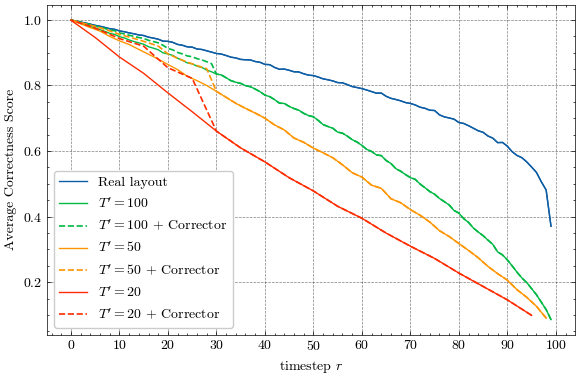

In [14]:
# plot
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

ts = get_diffusion_idx_list(model.model.num_timesteps, model.model.num_timesteps)
reg_avg_scores = results_dict['real']['reg_avg_scores']
avg_ys = np.array([s.cpu().item() for s in reg_avg_scores])
ax.plot(ts, avg_ys)

for dic in plot_list:
    key = dic['key']
    num_timesteps = 100 if key == 'real' else config_dict[key]['num_timesteps']
    ts = get_diffusion_idx_list(model.model.num_timesteps, num_timesteps)
    reg_avg_scores = results_dict[key]['reg_avg_scores']
    avg_ys = np.array([s.cpu().item() for s in reg_avg_scores])
    ax.plot(ts, avg_ys, label=dic['name'], **get_plt_kwargs(dic))

ax.legend(facecolor='inherit')
ax.set_xticks(np.arange(0, 110, 10))
ax.set_xlabel(r"timestep $r$")
ax.set_ylabel("Average Correctness Score")
# plt.title("Timestep vs Avg Corrector Score (Regular Tokens)")
plt.show()